<a href="https://colab.research.google.com/github/rikoimade/px-liq/blob/main/geothermometry_riko.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Abstract
Here I present the implementation of PyTorch neural networks for Pyroxene-Liquid thermobarometry. It took 25 chemical compositions from minerals as the input, and pressure and temperature prediction as to the output simultaneously. The current implementation yields pressure and temperature uncertainty of 0.7 GPa and 16 K, respectively.



# Introduction

Estimating pressure-temperature (P-T) of magmatic process is important in understanding many geological processes such as volcanism, crustal dynamics and tectonics, and ore deposition. Discussion of algorithms for estimating P-T conditions from geochemical data seems to be a never-ending topic in geochemistry, but the tools have not changed much over the 20th and 21st centuries (Putirka, 2008). 

Typically thermodynamic equilibria of mineral assemblages are exploited to estimate P-T (see Putirka, 2008 for a review). Over the last two centuries, this has been a de facto method, and as a result thermodynamic terms have been added to update the models, and lots of effort have been gone into validating them. The drawbacks with every model deviation and updates, more and more terms are added, which makes the model becomes unwieldy complex. For example, the last update pyroxene thermobarometry has more than 20 energy terms (Sack & Ghiorso, 1994a, 1994b, 1994c). Furthermore, the experiments required to determine the thermodynamic data for these models are very complex and time consuming and require specialised equipment. Due to kinetic constraints, these experiments generally have to be performed at unrealistic conditions and the results are then extrapolated to geologically relevant conditions, introducing unknown uncertainties. 

As machine learning becomes more common, we will find it in every application. Geological applications are well suited for machine learning because there is an abundance of geochemical data available across multiple databases (e.g. Georoc, etc.). However, the application of machine learning and other forms of artificial intelligence to geological problems is in its infancy.

Some of the early implementations of machine learning in geology used support vector machines (Petrelli & Perugini, 2016) and random forest frameworks (Schönig et al. 2021) to classify rocks from geochemical data.There has also been effort to integrate machine learning methods to online classification with energy-dispersive X-ray spectra (Hrstka et al., 2018).

Machine learning has also been applied to geothermal problems. One of the earliest implementations is using deep neural networks for Na/K geothermometry of thermal waters (Serpen et al., 2009). Further development have been focused on predicting geothermal temperature (Los Alamos National Laboratory et al., 2020)

On the other hand, there are only a handful of machine learning implementations for magmatic thermobarometry. Most recently, researchers have applied random forest algorithms to pyroxene-liquid (Jorgenson et al., 2021; Petrelli et al., 2020)amphibole-clinopyroxene thermobarometry (Higgins 2021). The more advanced topic is determining the pressure-temperature (P-T) path for compositionally zoned minerals (Kuwatani et al., 2012, 2018).

One tricky thing about estimating pressure and temperature in pegtrological framework is that the two variables are non-independent parameters. Observable mineral assemblages are dependent on both pressure and temperature. Therefore, it will be difficult to model pressure and temperature using gaussian process regression (Rasmussen & Williams, 2008). On the other hand, Artificial Neural Networks (ANN) has more flexibility for this. However, estimating prediction uncertainty in ANN is not straightforward (Gawlikowski et al., 2021).

In this paper, we present a method for estimating P-T conditions of magmatic rocks using ANN. The uncertainty of our method is estmated using the standard deviation of the prediction variation.


# Method

## Datasets Preparation
In this implementation, I am going to use Pyroxene - Melt datasets that have been compiled by (Petrelli et al., 2020) from supplementary file jgrb54402-sup-0002-2020jb020130-ts01.xlsx. The file contains several spreadsheets (i.e Table S1 to Table S2). In this case, we are going to use Table S3 as Training/Validation Datasets, and Table S4 for Test. 
We have 

Input data consist of 22 pairs of melt and pyroxene compositons. The output targets are Pressure and Temperature. Non-available cell quantities are filled with zeroes.



## Modeling
A flexible neural network class was constructed using the PyTorch library (Paszke et al., 2019). The neural network class is constructed as close as possible to the scikit-learn workflow (Pedregosa et al., 2011). That includes ‘fit’ and ‘predict’ methods for training and evaluation, respectively. The basic class inherits from PyTorch NN modules.

The model's parameters ― weight and bias ―  were adjusted automatically by training the model with the mineral and melt compositions over multiple iterations (epochs). During training, the training data were split further into further sub-training and validation portions in 10 fold cross-validation. The training iteration objective is to minimize the difference between the experiment's results and the prediction given in mean square error (MSE).

$MSE = \dfrac{1}{n} \Sigma_{i=1}^{n}\left(y_{true} - y_{pred}\right)^2$


In the current implementation, we use Adam optimizer (Kingma & Ba, 2014) as implemented     in PyTorch library and mean squared error as the loss function to minimize.

## Prediction's uncertainty
To quantify prediction uncertainty, we construct multiple deep neural network models that can predict the P-T output given the mineral and melt composition. To do this I utilize gp_minimze function from scikit-optimize (Head et al., 2018) to generate multiple sets of neural network hyperparameters. Here I take the standard deviation of the prediction variation as the prediction uncertainty.




# Results
Hyperparameters optimization produced 10 unique structures of the neural networks. All of the structures consist of 25 inputs (oxide compositions) and 2 outputs (pressure and temperature). The simplest structure has only one hidden layer with 100 nodes in the hidden layers. The most complex structure suggested consists of 5 hidden layers with 229 nodes in the hidden layers. For simplicity, Fig 1 only shows one tenth the number of nodes for layers with more than 20 nodes.

<img src='figures/nn-summary.svg'>
Fig.1 Visualization of multiple generated neural networks that minimize the prediction and the experimental results

The temperature prediction is quite robust with $R^2$ values 0.995 and 0.932 for the training data and test data, respectively (Fig. 2). The model’s training results are plotted as a red circles, with the associated prediction uncertainty as a vertical error bar. On average the current modeling gives out about 0.71 GPa (7 kBar) pressure uncertainty. 

Pressures are mostly underestimated above 2.5 GPaand seem rather overestimated below 1GPa. On the other hand, temperature prediction is much better, with about 16 K prediction uncertainty. There are clusters of over-prediction around 1600 K data points as well as those at around 1100 K data clusters.

<img src='figures/results.svg'>
Fig. 2 Modeling results of Pyroxene-Liquid datasets, plotted the predicted value and the true value.

# Discussion

The neural network is versatile. In a sense that vastly different neural network structures can give a reasonable prediction.

In the current implementation, we remove the subjectivity of deciding the range of equations to use as well as reduce the number of equations to use for a given composition. The model is a single monolithic model that predicts pressure and temperature simultaneously.

Given the straightforward nature of the current method, 7 kBar uncertainty of the prediction is comparable to those from the thermodynamic equilibria method i.e 4-5 kBar (Putirka, 2008). I believe that the prediction variation can be further reduced with a much longer training iteration. On the other hand, temperature prediction uncertainty is much better, i.e 16 K as compared to 45 K. Further training iteration may cause overfitting to the temperature model.


## Limit to the method
The current method also required certain programming knowledge to implement it efficiently. In the current model, I have used extra computing power provided by dedicated GPU, i.e through the PyTorch package.


# Conclusions
Here we have demonstrated the flexibility of the neural network framework for geothermometry. That a single model, without many priories on geological knowledge, provides relatively accurate pressure and temperature prediction. The relative simplicity of the method makes it relatively simple to implement in other mineral geothermometry systems.

# Refference
Gawlikowski, J., Tassi, C. R. N., Ali, M., Lee, J., Humt, M., Feng, J., Kruspe, A., Triebel, R., Jung, P., Roscher, R., Shahzad, M., Yang, W., Bamler, R., & Zhu, X. X. (2021). A Survey of Uncertainty in Deep Neural Networks. ArXiv:2107.03342 [Cs, Stat]. http://arxiv.org/abs/2107.03342

Head, T., MechCoder, Louppe, G., Shcherbatyi, I., fcharras, Vinícius, Z., cmmalone, Schröder, C., nel215, Campos, N., Young, T., Cereda, S., Fan, T., rene-rex, Shi, K. (KJ), Schwabedal, J., carlosdanielcsantos, Hvass-Labs, Pak, M., … Fabisch, A. (2018). scikit-optimize/scikit-optimize: V0.5.2. Zenodo. https://doi.org/10.5281/zenodo.1207017

Hrstka, T., Gottlieb, P., Skala, R., Breiter, K., & Motl, D. (2018). Automated mineralogy and petrology—Applications of TESCAN Integrated Mineral Analyzer (TIMA). Journal of Geosciences, 63(1), 47–63. https://doi.org/10.3190/jgeosci.250

Jorgenson, C., Higgins, O., Petrelli, M., Bégué, F., & Caricchi, L. (2021, August 19). A machine learning based approach to clinopyroxene thermobarometry: Model optimisation and distribution for use in Earth Sciences (world) [Preprint]. Earth and Space Science Open Archive; Earth and Space Science Open Archive. https://doi.org/10.1002/essoar.10507770.1

Kingma, D. P., & Ba, J. (2014). Adam: A Method for Stochastic Optimization. https://arxiv.org/abs/1412.6980v9

Kuwatani, T., Nagata, K., Okada, M., & Toriumi, M. (2012). Precise estimation of pressure–temperature paths from zoned minerals using Markov random field modeling: Theory and synthetic inversion. Contributions to Mineralogy and Petrology, 163(3), 547–562. https://doi.org/10.1007/s00410-011-0687-3

Kuwatani, T., Nagata, K., Yoshida, K., Okada, M., & Toriumi, M. (2018). Bayesian probabilistic reconstruction of metamorphic P–T paths using inclusion geothermobarometry. Journal of Mineralogical and Petrological Sciences, 113(2), 82–95. https://doi.org/10.2465/jmps.170923

Los Alamos National Laboratory, Ahmmed, B., Vesselinov, V., Vesselinov, V., Mudunuru, M. K., & Mudunuru, M. K. (2020). MACHINE LEARNING TO CHARACTERIZE REGIONAL GEOTHERMAL RESERVOIRS IN THE WESTERN USA. 358249. https://doi.org/10.1130/abs/2020AM-358249

Paszke, A., Gross, S., Massa, F., Lerer, A., Bradbury, J., Chanan, G., Killeen, T., Lin, Z., Gimelshein, N., & Antiga, L. (2019). Pytorch: An imperative style, high-performance deep learning library. Advances in Neural Information Processing Systems, 32, 8026–8037.

Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., Blondel, M., Prettenhofer, P., Weiss, R., Dubourg, V., Vanderplas, J., Passos, A., Cournapeau, D., Brucher, M., Perrot, M., & Duchesnay, É. (2011). Scikit-learn: Machine Learning in Python. Journal of Machine Learning Research, 12(85), 2825–2830.
Petrelli, M., Caricchi, L., & Perugini, D. (2020). Machine Learning Thermo-Barometry: Application to Clinopyroxene-Bearing Magmas. Journal of Geophysical Research: Solid Earth, 125(9), e2020JB020130. https://doi.org/10.1029/2020JB020130

Petrelli, M., & Perugini, D. (2016). Solving petrological problems through machine learning: The study case of tectonic discrimination using geochemical and isotopic data. Contributions to Mineralogy and Petrology, 171(10), 81. https://doi.org/10.1007/s00410-016-1292-2

Putirka, K. D. (2008). Thermometers and barometers for volcanic systems. Reviews in Mineralogy and Geochemistry, 69(1), 61–120.
Rasmussen, C. E., & Williams, C. K. I. (2008). Gaussian processes for machine learning (3. print). MIT Press.
Sack, R. O., & Ghiorso, M. S. (1994a). Thermodynamics of multicomponent pyroxenes: I. Formulation of a general model. Contributions to Mineralogy and Petrology, 116(3), 277–286. https://doi.org/10.1007/BF00306497

Sack, R. O., & Ghiorso, M. S. (1994b). Thermodynamics of multicomponent pyroxenes: II. Phase relations in the quadrilateral. Contributions to Mineralogy and Petrology, 116(3), 287–300. https://doi.org/10.1007/BF00306498

Sack, R. O., & Ghiorso, M. S. (1994c). Thermodynamics of multicomponent pyroxenes: III. Calibration of Fe2+(Mg)-1, TiAl2(MgSi2)-1, TiFe23+(MgSi2)-1, AlFe3+(MgSi)-1, NaAl(CaMg)-1, Al2(MgSi)-1 and Ca(Mg)-1 exchange reactions between pyroxenes and silicate melts. Contributions to Mineralogy and Petrology, 118(3), 271–296. https://doi.org/10.1007/BF00306648

Schönig, J., von Eynatten, H., Tolosana-Delgado, R., & Meinhold, G. (2021). Garnet major-element composition as an indicator of host-rock type: A machine learning approach using the random forest classifier. Contributions to Mineralogy and Petrology, 176(12), 98. https://doi.org/10.1007/s00410-021-01854-w

Serpen, G., Palabiyik, Y., & Serpen, U. (2009). An artificial neural network model for Na/K geothermometer. Proceedings of the 34th Workshop on Geothermal Reservoir Engineering, Stanford University, Stanford, USA, 1–12.

# Supplementary

## Codes

In [1]:
!pip install scikit-optimize
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import joblib
import datetime
import os

import sklearn
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

import skopt
from skopt import gp_minimize

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


     |████████████████████████████████| 100 kB 3.5 MB/s 


In [2]:
today = datetime.date.today().isoformat()
plt.style.use('ggplot')

In [3]:
try:
    %load_ext autotime
except:
    !pip install ipython-autotime
    %load_ext autotime

time: 213 µs (started: 2022-01-07 06:30:14 +00:00)


In [4]:
os.path.isdir

<function genericpath.isdir>

time: 5.6 ms (started: 2022-01-07 06:30:14 +00:00)


In [5]:
for folder in ['models', 'figures', 'figure-archives', 'results', 'result-archives']:
  if os.path.isdir(folder) == False:
    os.mkdir(folder)

time: 3.9 ms (started: 2022-01-07 06:30:14 +00:00)


### Prep Data

In [6]:
url = ''
! wget https://agupubs.onlinelibrary.wiley.com/action/downloadSupplement?doi=10.1029%2F2020JB020130&file=jgrb54402-sup-0002-2020JB020130-ts01.xlsx -O pittrelli-2020.zip

/bin/bash: -O: command not found
--2022-01-07 06:30:14--  https://agupubs.onlinelibrary.wiley.com/action/downloadSupplement?doi=10.1029%2F2020JB020130
Resolving agupubs.onlinelibrary.wiley.com (agupubs.onlinelibrary.wiley.com)... 162.159.130.87, 162.159.129.87, 2606:4700:7::a29f:8257, ...
Connecting to agupubs.onlinelibrary.wiley.com (agupubs.onlinelibrary.wiley.com)|162.159.130.87|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 823297 (804K) [application/zip]
Saving to: ‘downloadSupplement?doi=10.1029%2F2020JB020130’

downloadSupplement? 100%[===================>] 804.00K  1019KB/s    in 0.8s    

2022-01-07 06:30:15 (1019 KB/s) - ‘downloadSupplement?doi=10.1029%2F2020JB020130’ saved [823297/823297]

time: 1.77 s (started: 2022-01-07 06:30:14 +00:00)


In [7]:
! ls

'downloadSupplement?doi=10.1029%2F2020JB020130'   models	    sample_data
 figure-archives				  result-archives
 figures					  results
time: 137 ms (started: 2022-01-07 06:30:15 +00:00)


In [8]:
! ls

'downloadSupplement?doi=10.1029%2F2020JB020130'   models	    sample_data
 figure-archives				  result-archives
 figures					  results
time: 134 ms (started: 2022-01-07 06:30:16 +00:00)


In [9]:
! unzip downloadSupplement?doi=10.1029%2F2020JB020130

Archive:  downloadSupplement?doi=10.1029%2F2020JB020130
  inflating: jgrb54402-sup-0002-2020jb020130-ts01.xlsx  
  inflating: jgrb54402-sup-0001-2020jb020130-si.docx  
  inflating: jgrb54402-sup-0004-2020jb020130-ds01.zip  
  inflating: jgrb54402-sup-0003-2020jb020130-ts02.xlsx  
time: 130 ms (started: 2022-01-07 06:30:16 +00:00)


In [10]:
wb = pd.ExcelFile("jgrb54402-sup-0002-2020jb020130-ts01.xlsx")
#wb = pd.ExcelFile('pittrelli-2020-ts01.xlsx')

time: 741 ms (started: 2022-01-07 06:30:16 +00:00)


In [11]:
wb.sheet_names

['Table S1', 'Table S2', 'Table S3', 'Table S4']

time: 5.72 ms (started: 2022-01-07 06:30:17 +00:00)


In [12]:
df1 = wb.parse(sheet_name = 'Table S3', skiprows=1)
df2 = wb.parse(sheet_name = 'Table S4', skiprows=1)

time: 46.6 ms (started: 2022-01-07 06:30:17 +00:00)


In [13]:
features = list(df1)
targets = list(df1)[-2:]
features= list(df1)[1:-2]
features.remove('Unnamed: 13')
features.remove('Unnamed: 24')
#features.remove(''P_GPa')

time: 3.84 ms (started: 2022-01-07 06:30:17 +00:00)


In [14]:
features, targets

(['SiO2',
  'TiO2',
  'Al2O3',
  'FeOt',
  'MnO',
  'MgO',
  'CaO',
  'Na2O',
  'K2O',
  'Cr2O3',
  'P2O5',
  'H2O',
  'SiO2.1',
  'TiO2.1',
  'Al2O3.1',
  'FeOt.1',
  'MnO.1',
  'MgO.1',
  'CaO.1',
  'Na2O.1',
  'K2O.1',
  'Cr2O3.1'],
 ['P_GPa', 'T_K'])

time: 7.45 ms (started: 2022-01-07 06:30:17 +00:00)


In [15]:
X_train = df1[features].astype('float32')

time: 7.06 ms (started: 2022-01-07 06:30:17 +00:00)


In [16]:
X_test = df2[features].astype('float32')

time: 3.67 ms (started: 2022-01-07 06:30:17 +00:00)


In [17]:
X_train = X_train.fillna(0)

time: 2.61 ms (started: 2022-01-07 06:30:17 +00:00)


In [18]:
X_test = X_test.fillna(0)

time: 3.55 ms (started: 2022-01-07 06:30:17 +00:00)


In [19]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 22 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   SiO2     850 non-null    float32
 1   TiO2     850 non-null    float32
 2   Al2O3    850 non-null    float32
 3   FeOt     850 non-null    float32
 4   MnO      850 non-null    float32
 5   MgO      850 non-null    float32
 6   CaO      850 non-null    float32
 7   Na2O     850 non-null    float32
 8   K2O      850 non-null    float32
 9   Cr2O3    850 non-null    float32
 10  P2O5     850 non-null    float32
 11  H2O      850 non-null    float32
 12  SiO2.1   850 non-null    float32
 13  TiO2.1   850 non-null    float32
 14  Al2O3.1  850 non-null    float32
 15  FeOt.1   850 non-null    float32
 16  MnO.1    850 non-null    float32
 17  MgO.1    850 non-null    float32
 18  CaO.1    850 non-null    float32
 19  Na2O.1   850 non-null    float32
 20  K2O.1    850 non-null    float32
 21  Cr2O3.1  850 non

In [20]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119 entries, 0 to 118
Data columns (total 22 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   SiO2     119 non-null    float32
 1   TiO2     119 non-null    float32
 2   Al2O3    119 non-null    float32
 3   FeOt     119 non-null    float32
 4   MnO      119 non-null    float32
 5   MgO      119 non-null    float32
 6   CaO      119 non-null    float32
 7   Na2O     119 non-null    float32
 8   K2O      119 non-null    float32
 9   Cr2O3    119 non-null    float32
 10  P2O5     119 non-null    float32
 11  H2O      119 non-null    float32
 12  SiO2.1   119 non-null    float32
 13  TiO2.1   119 non-null    float32
 14  Al2O3.1  119 non-null    float32
 15  FeOt.1   119 non-null    float32
 16  MnO.1    119 non-null    float32
 17  MgO.1    119 non-null    float32
 18  CaO.1    119 non-null    float32
 19  Na2O.1   119 non-null    float32
 20  K2O.1    119 non-null    float32
 21  Cr2O3.1  119 non

In [21]:
y_train = df1[targets].astype('float32')

time: 3.59 ms (started: 2022-01-07 06:30:17 +00:00)


In [22]:
y_test = df2[targets].astype('float32')

time: 3.71 ms (started: 2022-01-07 06:30:17 +00:00)


### Scaler

In [23]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

time: 13 ms (started: 2022-01-07 06:30:17 +00:00)


In [24]:
X_test = scaler.transform(X_test)

time: 5.85 ms (started: 2022-01-07 06:30:17 +00:00)


In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
#print('Cuda Devices {}'.format(torch.cuda.get_device_name(torch.cuda.current_device())))

Using device: cpu
time: 109 ms (started: 2022-01-07 06:30:17 +00:00)


In [26]:
X_torch = Variable(torch.tensor(X_train, device=device))
y_torch = Variable(torch.tensor(np.asarray(y_train), device=device))

time: 53.4 ms (started: 2022-01-07 06:30:17 +00:00)


In [27]:
X_test_torch = Variable(torch.tensor(X_test, device=device))
y_test_torch = Variable(torch.tensor(np.asarray(y_test), device=device))

time: 3.09 ms (started: 2022-01-07 06:30:17 +00:00)


### Modeling

In [28]:
class Net(nn.Module):
    def __init__(self,n_input_nodes, n_hidden_layers, 
                 n_hidden_nodes, n_output_nodes ):
        """
        n_feature : number of input feature nodes
        n_hidden : number of nodes in the hidden layer
        n_output : number of nodes in the output layer
        
        d_hidden : number of hidden layers
        """
        
        super(Net, self).__init__() ## inherit init function from the ancestor
        
        
        self.input = nn.Linear(n_input_nodes, n_hidden_nodes)
        self.hidden = nn.Linear(n_hidden_nodes, n_hidden_nodes)
        self.output = nn.Linear(n_hidden_nodes, n_output_nodes)
        
        self.l_hidden = n_hidden_layers
        
    def forward(self, x):
        x = self.input(x)
        
        for i in range(self.l_hidden):
            x = self.hidden(x)
            x = F.relu(x)
        x = self.output(x)
        
        return x
    
    def predict(self, x):
        self.eval()
        return self.forward(x)
    
    def fit(self, train_x, train_y, epochs=100, verbose=True):
        """
        train_x : training x
        train_y : training y
        
        """
        self.train()
        
        optimizer = torch.optim.Adam(self.parameters()) ## SGD gave 'nan'
        loss_func = nn.MSELoss()

        n_splits = 10
        kf = KFold(n_splits=n_splits)
        
        for train_index, val_index in kf.split(train_x):
            xx_train, xx_val = train_x[train_index], train_x[val_index]
            yy_train, yy_val = train_y[train_index], train_y[val_index]
        
            for t in range(epochs):

                pred = self.forward(xx_train)     
    
                loss = loss_func(pred, yy_train)

                optimizer.zero_grad()

                loss.backward()  # backpropagation
                optimizer.step() # update gradient

                if verbose: 

                    val_loss = loss_func(self.predict(xx_val), yy_val)
  
                    print('\t{:}/{:}-- loss: {:0.3f} val_loss: {:.3f}'.format(t+1, epochs, loss, val_loss))
        
    
       

time: 53.4 ms (started: 2022-01-07 06:30:17 +00:00)


In [29]:
def func_t(input_array, train_x=X_torch, train_y=y_torch):
    n_hidden_layers, n_hidden_nodes = input_array
    n_input_nodes = len(features)
    n_output_nodes = 2
    
    model = Net(n_input_nodes=n_input_nodes, 
            n_hidden_layers=n_hidden_layers, 
            n_hidden_nodes=n_hidden_nodes,
            n_output_nodes=n_output_nodes) 

    model.to(device)
    
    model.fit(train_x=train_x, train_y=train_y, epochs=100, verbose=False)
    
    prediction = model.predict(train_x)
    prediction = prediction.cpu().data.numpy()
    
    y_true = np.asarray(y_train)
    
    del model
    r2 = metrics.r2_score(y_true, prediction)
    
    return -r2

time: 13.3 ms (started: 2022-01-07 06:30:17 +00:00)


In [30]:
bounds = [(1, 30), (len(features), 300) ] ## n_hidden_layers, n_nodes

time: 1.41 ms (started: 2022-01-07 06:30:17 +00:00)


#### generate hp

In [31]:
res_tdict = {}

n_models = 10

for i in range(n_models):
    res_tdict[i] = gp_minimize(func_t, bounds, verbose=False, 
                               initial_point_generator = 'lhs',
                               n_calls = 10
                              )
    
    joblib.dump(res_tdict[i], 'models/res_t{:}.joblib'.format(i))
    joblib.dump(res_tdict[i], 'models/res_t{:}_{:}.joblib'.format(i, today))
    n_l, n_n = res_tdict[i].x
    print('\t{:}/{:} end R2={:.3f}, n_layers={:}, n_nodes={:}\n'.format(i+1, n_models, -res_tdict[i].fun, n_l, n_n))


	1/10 end R2=0.848, n_layers=2, n_nodes=195

	2/10 end R2=0.580, n_layers=3, n_nodes=52

	3/10 end R2=0.745, n_layers=1, n_nodes=262

	4/10 end R2=0.708, n_layers=3, n_nodes=209

	5/10 end R2=0.764, n_layers=3, n_nodes=262

	6/10 end R2=0.862, n_layers=2, n_nodes=294

	7/10 end R2=0.600, n_layers=3, n_nodes=34

	8/10 end R2=0.575, n_layers=28, n_nodes=273

	9/10 end R2=0.727, n_layers=3, n_nodes=200

	10/10 end R2=0.746, n_layers=2, n_nodes=182

time: 1h 28min 10s (started: 2022-01-07 06:30:17 +00:00)


#### generate models


In [32]:
training_epochs = 1000
models_tdict={}
for i in range(n_models):
            

        n_layers, n_nodes = res_tdict[i].x
        
        
        m = Net(n_input_nodes=len(features),
                n_hidden_layers = n_layers, 
                n_hidden_nodes = n_nodes, 
                n_output_nodes = 2
               )
        
        m.to(device)
        
        m.fit(train_x = X_torch, train_y = y_torch, verbose=False,
              epochs=training_epochs)
        
        models_tdict['{:}'.format(i)]  = m
        print('\t model {:}/{:} completed'.format(i+1, n_models))

	 model 1/10 completed
	 model 2/10 completed
	 model 3/10 completed
	 model 4/10 completed
	 model 5/10 completed
	 model 6/10 completed
	 model 7/10 completed
	 model 8/10 completed
	 model 9/10 completed
	 model 10/10 completed
time: 53min 49s (started: 2022-01-07 07:58:28 +00:00)


In [33]:
!ls

'downloadSupplement?doi=10.1029%2F2020JB020130'
 figure-archives
 figures
 jgrb54402-sup-0001-2020jb020130-si.docx
 jgrb54402-sup-0002-2020jb020130-ts01.xlsx
 jgrb54402-sup-0003-2020jb020130-ts02.xlsx
 jgrb54402-sup-0004-2020jb020130-ds01.zip
 models
 result-archives
 results
 sample_data
time: 151 ms (started: 2022-01-07 08:52:18 +00:00)


#### Make prediction on training data

In [34]:
df_T = pd.DataFrame(index=y_train.index)
df_P = pd.DataFrame(index=y_train.index)

time: 10.2 ms (started: 2022-01-07 08:52:18 +00:00)


In [35]:
for i in range(n_models):
    y_preds = models_tdict[str(i)].predict(X_torch)
    y_p = y_preds.cpu().data.numpy()
    df_P[i]=y_p[:,0]
    df_T[i]=y_p[:,1]

time: 164 ms (started: 2022-01-07 08:52:18 +00:00)


In [36]:
df_P['mean'] = df_P[[j for j in range(10)]].mean(axis=1)
df_T['mean'] = df_T[[j for j in range(10)]].mean(axis=1)

df_P['std'] = df_P[[j for j in range(10)]].std(axis=1)
df_T['std'] = df_T[[j for j in range(10)]].std(axis=1)

time: 29.2 ms (started: 2022-01-07 08:52:18 +00:00)


### Make Prediction on test data

In [37]:
df_T_test = pd.DataFrame(index=y_test.index)
df_P_test = pd.DataFrame(index=y_test.index)

time: 2.81 ms (started: 2022-01-07 08:52:18 +00:00)


In [38]:
for i in range(n_models):
    y_preds = models_tdict[str(i)].predict(X_test_torch)
    y_p = y_preds.cpu().data.numpy()
    df_P_test[i]=y_p[:,0]
    df_T_test[i]=y_p[:,1]

time: 49.5 ms (started: 2022-01-07 08:52:18 +00:00)


In [39]:
df_P_test['mean'] = df_P_test[[j for j in range(10)]].mean(axis=1)
df_T_test['mean'] = df_T_test[[j for j in range(10)]].mean(axis=1)

df_P_test['std'] = df_P_test[[j for j in range(10)]].std(axis=1)
df_T_test['std'] = df_T_test[[j for j in range(10)]].std(axis=1)

time: 14.6 ms (started: 2022-01-07 08:52:18 +00:00)


### Plot Training Results

In [40]:
y_test_numpy = np.asarray(y_test)
y_train_numpy = np.asarray(y_train)

time: 2.41 ms (started: 2022-01-07 08:52:18 +00:00)


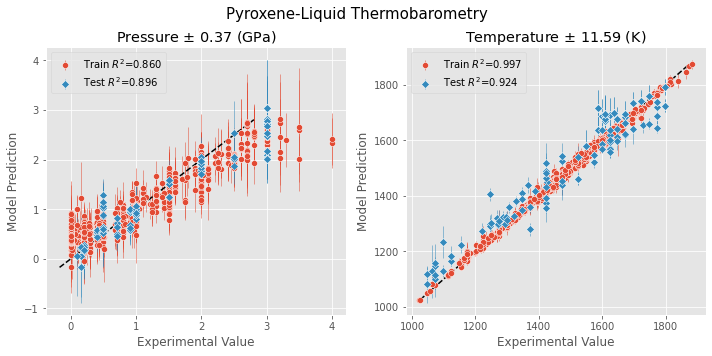

time: 2.74 s (started: 2022-01-07 09:00:32 +00:00)


In [52]:
fig, axis = plt.subplots(ncols=2, figsize=(10,5))

train_df = [df_P, df_T]
test_df = [df_P_test, df_T_test]
units = ['GPa', 'K']
titles = ['Pressure', 'Temperature']

for i, d, d_test, ax, title, unit in zip(range(2), train_df, test_df, axis.ravel(), titles, units):
    ax.plot([d['mean'].min(), d['mean'].max()], [d['mean'].min(), d['mean'].max()], 
            ls='--', c='k')
    
    xx = y_train_numpy[:,i]
    yy = d['mean']
    unc = d['std'].mean()
    
    r2 = metrics.r2_score(xx,yy)
    
    ax.errorbar(x=xx, y=yy, yerr=d['std'], 
                ls='', marker='o', mec='w', lw=0.5, mew=0.5, 
                label="Train $R^2$={:.3f}".format(r2))
    
    
    xx = y_test_numpy[:,i]
    yy = d_test['mean']
    
    
    r2 = metrics.r2_score(xx,yy)
    
    ax.errorbar(x=xx, y=yy, yerr=d_test['std'], 
                ls='', marker='D', mec='w', lw=0.5, mew=0.5, 
                label="Test $R^2$={:.3f}".format(r2))
        
    ax.set_title('{:} $\pm $ {:.2f} ({:})'.format(title, unc, unit))
    ax.set_xlabel('Experimental Value')
    ax.set_ylabel('Model Prediction')
    
    ax.legend(loc='upper left')
    
fig.suptitle('Pyroxene-Liquid Thermobarometry', fontsize=15)
    
fig.tight_layout(rect=(0,0,1,0.95))

for ext in ['png', 'svg', 'pdf']:
    fig.savefig('figures/results.{}'.format(ext))
    fig.savefig('figure-archives/results_{:}.{:}'.format(today, ext))

In [42]:
df_T_test['std'].describe()

count    119.000000
mean      38.757416
std       18.264521
min       12.393688
25%       23.758505
50%       34.400898
75%       54.760395
max       94.985847
Name: std, dtype: float64

time: 23.6 ms (started: 2022-01-07 08:52:22 +00:00)


In [43]:
df_T['std'].describe()

count    850.000000
mean      11.589986
std        6.310336
min        2.375678
25%        7.467561
50%       10.195367
75%       13.595514
max       66.686577
Name: std, dtype: float64

time: 10.1 ms (started: 2022-01-07 08:52:22 +00:00)


In [44]:
### Save Models Ensemble

for i in range(n_models):
    torch.save(models_tdict['{:}'.format(i)].state_dict, 'cpxliq_{:}.pt'.format(i))

time: 23.4 ms (started: 2022-01-07 08:52:22 +00:00)


## Visualize Neural Networks

In [45]:


def visualize_nn(model_summary, threshold = 20, ax=None, fig = None, annot = True):
    """
    model_summary: a touple (nodes number, activation func)
    ax: axis to plot on
    vert : place the network vertically with input on top
    """
    
    if ax==None : fig, ax = plt.subplots()

    ### make the nodes
    ax.invert_yaxis()
    for i, nodes in enumerate(model_summary):
        
        if nodes[0]>threshold:
            nodes_to_draw = nodes[0]/10
        else:
            nodes_to_draw = nodes[0]
            
        nodes_to_draw = int(nodes_to_draw)
            
        x_pos = [x - nodes_to_draw/2 for x in range(nodes_to_draw)]
        y_pos = [i for x in range(nodes_to_draw)]
    

        ax.scatter(x=x_pos, y = y_pos, fc='w', ec='k', zorder=2)
        
        ax.axis('off')

        if i>0:


            ### now connect the nodes

            node0 = model_summary[i-1]
            node1 = model_summary[i]
            
            n0 = int(node0[0])
            n1 =  int(node1[0])
            
            if (node0[0]>threshold):
                n0 = int(node0[0]/10)
            if (node1[0]>threshold):
                n1 =  int(node1[0]/10)
                
            y0 = [i-1 for x in range(n0)]
            y1 = [i for x in range(n1)]

            x0 = [x - n0/2 for x in range(n0)]
            x1 = [x - n1/2 for x in range(n1)]

            xx0, xx1 = np.meshgrid(x0,x1)
            xx0 = xx0.reshape(-1,1)
            xx1 =xx1.reshape(-1,1)
            XX = np.hstack((xx0,xx1))

            yy0, yy1 = np.meshgrid(y0,y1)
            yy0 = yy0.reshape(-1,1)
            yy1 =yy1.reshape(-1,1)
            YY = np.hstack((yy0,yy1))

            for x, y in zip(XX, YY):
                ax.plot(x,y, lw=0.2, zorder=0)
        if annot:
            ax.text(s = str(nodes[0]), x=-0.5, y = i, 
                    va = 'bottom', ha='center')
                
    if annot:
        ax.text(s = 'input', x=-0.5, y = -.20, ha='center')
        ax.text(s = 'output', x=-0.5, y = len(model_summary)-0.8, ha='center')
    

time: 61.6 ms (started: 2022-01-07 08:52:22 +00:00)


In [46]:
def get_model_summary(x):
    summary = [(25,'Relu')]
    
    for i in range(x[0]):
        summary.append((x[1], 'Relu'))
        
    summary.append((2,'relu'))
    
    return summary

time: 4.35 ms (started: 2022-01-07 08:52:22 +00:00)


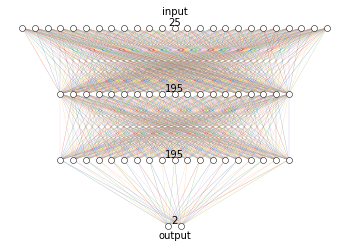

time: 1.51 s (started: 2022-01-07 08:52:22 +00:00)


In [47]:
summary = get_model_summary(res_tdict[0].x)
visualize_nn(summary, annot=True, threshold=30)

In [48]:
summary

[(25, 'Relu'), (195, 'Relu'), (195, 'Relu'), (2, 'relu')]

time: 3.9 ms (started: 2022-01-07 08:52:23 +00:00)


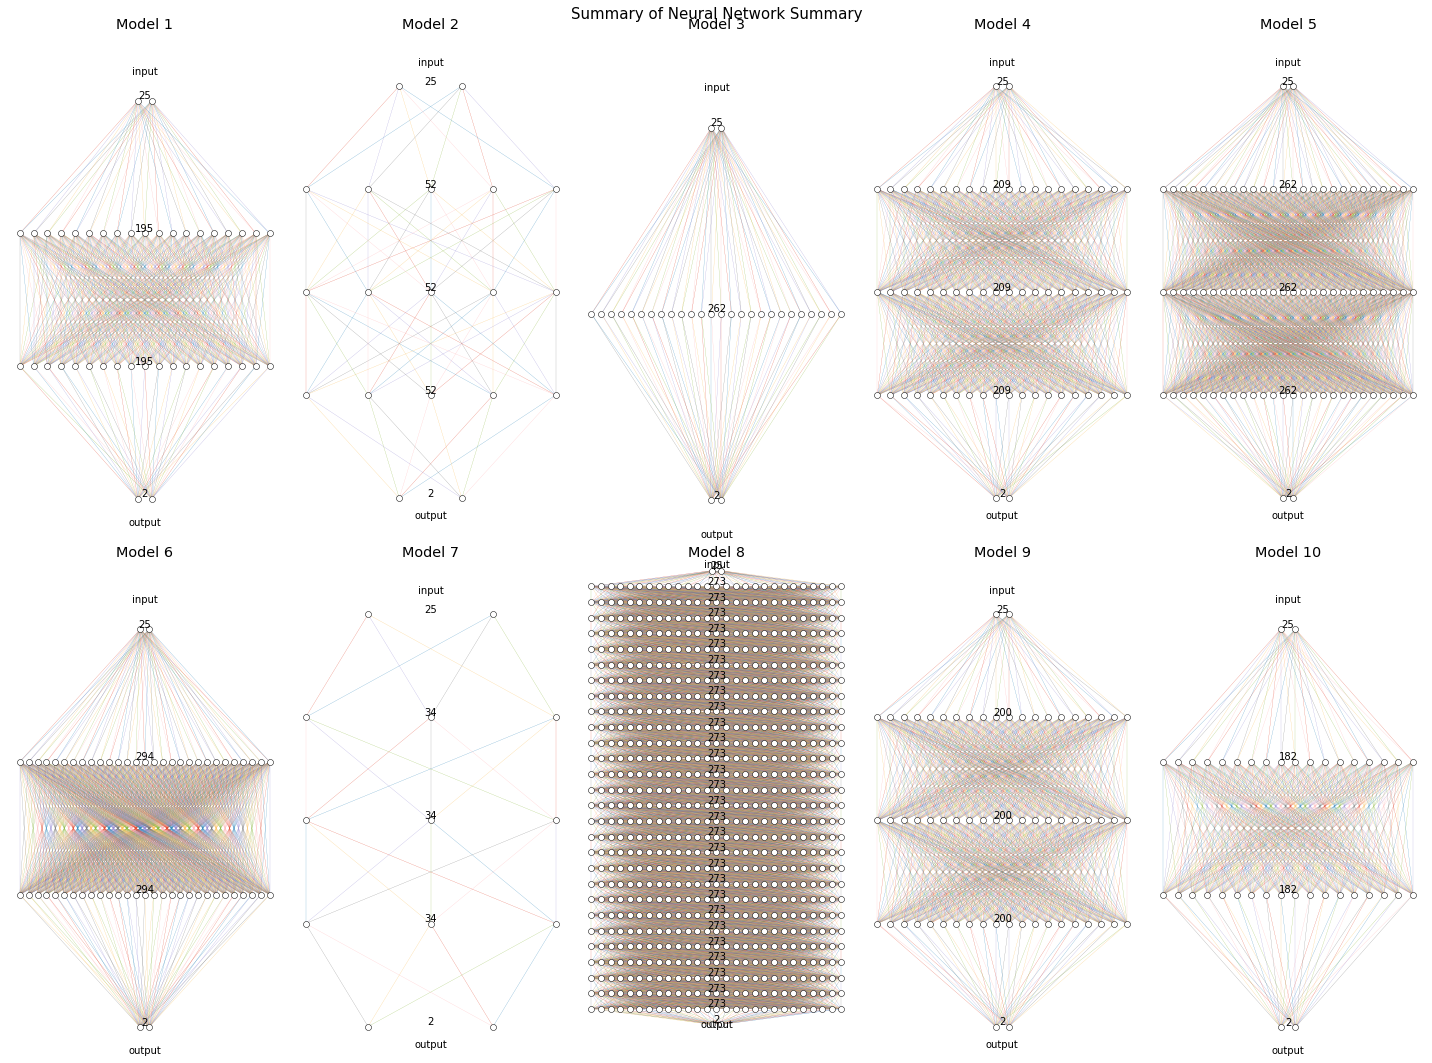

time: 1min 22s (started: 2022-01-07 08:52:23 +00:00)


In [49]:
fig, axis = plt.subplots(ncols=5, nrows=2, figsize=(20,15))

for i, ax in enumerate(axis.ravel()):
    summary = get_model_summary(res_tdict[i].x)
    visualize_nn(summary, ax=ax, threshold = 20)
    ax.set_title('Model {:}'.format(i+1))
    
    ax.set_ylim(top=-0.5)
    
fig.suptitle('Summary of Neural Network Summary', fontsize=15)    
fig.tight_layout(rect=(0,0,1,0.98))

for ext in ['png', 'pdf', 'svg']:
    fig.savefig('figures/nn-summary.{}'.format(ext))
    fig.savefig('figure-archives/nn-summary_{:}.{:}'.format(today,ext))
    


In [50]:
## save results
results =[df_T, df_P, df_T_test, df_P_test]
names = ['train_T', 'train_P', 'test_T', 'test_P']

for d, n in zip(results, names):
    d.to_excel('results/{:}.xlsx'.format(n))
    d.to_excel('result-archives/{:}_{:}.xlsx'.format(n, today))

time: 1.81 s (started: 2022-01-07 08:53:45 +00:00)


In [51]:
!ls

 cpxliq_0.pt
 cpxliq_1.pt
 cpxliq_2.pt
 cpxliq_3.pt
 cpxliq_4.pt
 cpxliq_5.pt
 cpxliq_6.pt
 cpxliq_7.pt
 cpxliq_8.pt
 cpxliq_9.pt
'downloadSupplement?doi=10.1029%2F2020JB020130'
 figure-archives
 figures
 jgrb54402-sup-0001-2020jb020130-si.docx
 jgrb54402-sup-0002-2020jb020130-ts01.xlsx
 jgrb54402-sup-0003-2020jb020130-ts02.xlsx
 jgrb54402-sup-0004-2020jb020130-ds01.zip
 models
 result-archives
 results
 sample_data
time: 157 ms (started: 2022-01-07 08:53:47 +00:00)
